Version modifier de :
https://www.kaggle.com/hmendonca/lightgbm-predictions-explained-with-shap-0-796

Nous avons changer le dataset train et test pour y inclure uniquement celui du train afin de garder les valeurs a predire
ajout d'un endroit pour mettre le path des fichiers  

# Remarque

Nous voulons réduire le dataset pour des raisons de performance.
Pour ce faire je vais bin sur le montant alloué au crédit. 

On peux imagine que on pourrait avoir quelques models en fonction du montant. 

De plus, si on pouvais avoir une metrique qui calcules les pertes financiéres associer au défault de crédit,
nous pourrions ajuster notre metrique de probabilité par tranche de crédit afin de minimiser les pertes financière. 

EX: 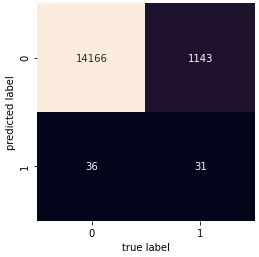  
  


Pour une tranche X
em moyenne, les défaut de crédit représente 100€,  
em moyenne, le profit générer représente 1€  
  
donc 

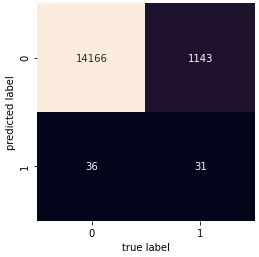

This kernel shows how one can try to explain the predictions of a given boosted tree model using the lib SHAP https://github.com/slundberg/shap

The model is then retrained only with the best features to avoid fitting to noise and improve our LB score ;)

It is based on the best performing public script and some other variants: i.e. https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features et al.

## Data directory
change below

In [1]:
DATA_DIRECTORY = r"C:\Users\juvaugha\Documents\PYTHON\OPCR PROJECTS\projet 7\Projet+Mise+en+prod+-+home-credit-default-risk"

In [2]:
# % du jeu de donner pour train et test
# need to be a number between 0.01 and 1
percentage_of_data_used = 0.2

In [14]:
import numpy as np
import pandas as pd
import shap
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
import os
import re

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [4]:
def geometric_mean(x):
    return np.exp(np.log(x[x>0]).mean())

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'application_train.csv'), nrows= num_rows)
    
    # Added by Julien VAUGHAN select a bin of AMT_CREDIT
    df = df[df['NAME_CONTRACT_TYPE']== 'Cash loans']
    bin_labels= [] 
    for num in range(int(1/percentage_of_data_used)):
        bin_labels.append(num)
    df['temp_bins'] = pd.qcut(df['AMT_CREDIT'], q=int(1/percentage_of_data_used), labels=bin_labels)
    df = df[df['temp_bins']== int(len(bin_labels)/2)]
          
       
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_EMPLOY_TO_BIRTH-18_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 18*365)
    df['NEW_BIRTH_TO_EMPLOY_RATIO'] = df['DAYS_BIRTH'] / (1 + df['DAYS_EMPLOYED'])
    df['NEW_INCOME_TO_ANNUITY_RATIO'] = df['AMT_INCOME_TOTAL'] / (1 + df['AMT_ANNUITY'])
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_EXT_SOURCES_MEDIAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].median(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_PROD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].prod(axis=1, skipna=True, min_count=1)
    df['NEW_EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_MAD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mad(axis=1, skipna=True)
    df['NEW_EXT_SOURCES_GEO'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].apply(geometric_mean, axis=1)
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOYED_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    df= df.drop(dropcolum,axis=1)
    
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(os.path.join(DATA_DIRECTORY, 'bureau.csv'), nrows = num_rows)
    bureau = bureau[bureau['SK_ID_CURR'].isin(df.SK_ID_CURR)]
    bb = pd.read_csv(os.path.join(DATA_DIRECTORY, 'bureau_balance.csv'), nrows = num_rows)
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(os.path.join(DATA_DIRECTORY, 'previous_application.csv'), nrows = num_rows)
    prev = prev[prev['SK_ID_CURR'].isin(df.SK_ID_CURR)]
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(os.path.join(DATA_DIRECTORY, 'POS_CASH_balance.csv'), nrows = num_rows)
    pos = pos[pos['SK_ID_CURR'].isin(df.SK_ID_CURR)]
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(os.path.join(DATA_DIRECTORY, 'installments_payments.csv'), nrows = num_rows)
    ins = ins[ins['SK_ID_CURR'].isin(df.SK_ID_CURR)]
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': [ 'mean',  'var'],
        'PAYMENT_DIFF': [ 'mean', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(os.path.join(DATA_DIRECTORY, 'credit_card_balance.csv'), nrows = num_rows)
    cc = cc[cc['SK_ID_CURR'].isin(df.SK_ID_CURR)]
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [5]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(train_df, train_target, test_df, num_folds, stratified=False, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    
    scores = []
    models = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_target)):
        train_x, train_y = train_df.iloc[train_idx], train_target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], train_target.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 300)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        
        print(roc_auc_score(valid_y, oof_preds[valid_idx]))
        scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        print('Fold %2d AUC : %.6f' % (n_fold + 1, scores[n_fold]))
        models.append(clf)
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    score = roc_auc_score(train_target, oof_preds)
    print('Full AUC score %.6f' % score)
    print('Mean AUC score %.6f' % np.mean(scores))
    # Write submission file and plot feature importance

    return  models, scores



In [6]:
%%time
debug = False
num_rows = 10000 if debug else None
#scores = {}

df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Save df"):
    df.to_csv('merged_df.csv.gz', compression='gzip', index=False)
with timer("Divide in training and test data"):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    feats = [f for f in df.set_index('SK_ID_CURR').columns if f not in ['TARGET','SK_ID_BUREAU','SK_ID_PREV', 'index']]
    
    
    
    train_df, test_df = train_test_split(df.set_index('SK_ID_CURR'))
        
    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))
    print("Train TARGET minority %: ,","{0:.2f}%".format( len(train_df[train_df['TARGET']==1])/ len(train_df))) 
    print("Test TARGET minority %: ,", "{0:.2f}%".format(len(test_df[test_df['TARGET']==1])/ len(test_df)))            
    
    train_target = train_df['TARGET']
    test_target = test_df['TARGET']
    
    train_df = train_df[feats]
    test_df = test_df[feats]
    del df
    gc.collect()

Bureau df shape: (45688, 91)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (50975, 217)
Process previous_applications - done in 14s
Pos-cash balance df shape: (50621, 17)
Process POS-CASH balance - done in 9s
Installments payments df shape: (51120, 22)
Process installments payments - done in 19s
Credit card balance df shape: (17441, 113)
Process credit card balance - done in 15s
Save df - done in 90s
Train samples: 40110, test samples: 13371
Train TARGET minority %: , 0.10%
Test TARGET minority %: , 0.10%
Divide in training and test data - done in 1s
Wall time: 3min 36s


In [7]:
%%time
models, scores = kfold_lightgbm(train_df, train_target, test_df, num_folds=5, stratified=False, debug=debug)

Starting LightGBM. Train shape: (40110, 705), test shape: (13371, 705)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[574]	training's auc: 0.917027	training's binary_logloss: 0.216105	valid_1's auc: 0.783045	valid_1's binary_logloss: 0.268274
0.78304461971433
Fold  1 AUC : 0.783045
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[474]	training's auc: 0.907145	training's binary_logloss: 0.219469	valid_1's auc: 0.781052	valid_1's binary_logloss: 0.288161
0.7810520440909725
Fold  2 AUC : 0.781052
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 300 rounds


In [8]:
scores

[0.78304461971433,
 0.7810520440909725,
 0.7691423005570357,
 0.7834213106353914,
 0.7944696069246033]

In [9]:
models

[LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
                min_child_weight=40, min_split_gain=0.0222415,
                n_estimators=10000, nthread=4, num_leaves=32, reg_alpha=0.04,
                reg_lambda=0.073, silent=-1, subsample=0.8715623, verbose=-1),
 LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
                min_child_weight=40, min_split_gain=0.0222415,
                n_estimators=10000, nthread=4, num_leaves=32, reg_alpha=0.04,
                reg_lambda=0.073, silent=-1, subsample=0.8715623, verbose=-1),
 LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
                min_child_weight=40, min_split_gain=0.0222415,
                n_estimators=10000, nthread=4, num_leaves=32, reg_alpha=0.04,
                reg_lambda=0.073, silent=-1, subsample=0.8715623, verbose=-1),
 LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
                min_child_weight

# export

In [11]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()


In [12]:
import joblib

In [13]:
joblib.dump(models[0], 'lgb.pkl')

['lgb.pkl']

In [14]:
train_df2['TARGET'] = train_target

In [15]:
test_df2['TARGET'] = test_target

In [16]:
train_df2.to_pickle("train_df.pkl")

In [17]:
test_df2.to_pickle("test_df.pkl")

In [18]:
y_proba = models[0].predict_proba(test_df, num_iteration=models[0].best_iteration_)[:, 1]

In [19]:
y_predict = models[0].predict(test_df, num_iteration=models[0].best_iteration_)

# try to get optimiser function

In [ ]:
y_test = test_target.copy()

In [ ]:
temp = test_df.copy()

In [ ]:
temp['y_proba'] = y_proba

In [ ]:
temp['y_predict'] = y_predict

In [ ]:
temp['y_proba'].describe(percentiles = [0.1, 0.85])

In [ ]:
temp['y_predict'].value_counts()

In [ ]:
temp[temp['y_predict']==1]['y_proba'].max()

In [ ]:
# get the ratio of default
default_ratio = len(train_df2[train_df2['TARGET']==1])/len(train_df2)

In [ ]:
print(temp.sort_values('y_proba', ascending=False).iloc[:int(default_ratio* len(temp))]['TARGET'].value_counts())

In [ ]:
temp.sort_values('y_proba', ascending=False).iloc[:int(default_ratio* len(temp))]['y_proba'].min()

In [ ]:
temp.sort_values('y_proba', ascending=False).iloc[:1-(int(default_ratio* len(temp)))]['TARGET'].value_counts()

In [ ]:
avg_lost_per_default = -100
avg_gain_per_good_customer = 1

temp['value_lost'] = np.where(temp['TARGET']==1, avg_lost_per_default, avg_gain_per_good_customer)

In [ ]:
from scipy.optimize import minimize_scalar



In [ ]:
346

In [ ]:
# !! MENTOR function to minimise lost

In [ ]:
y_proba

explain

In [ ]:
from explainerdashboard import ExplainerDashboard

In [ ]:
pd.DataFrame([models[0].feature_importances_], columns= [models[0].feature_name_], ).melt().sort_values('value', ascending=False).head(30)

In [ ]:
models[0].feature_name_

In [ ]:
asd

## ROC curve

In [30]:
from sklearn import metrics

In [31]:


from sklearn.metrics import confusion_matrix

In [23]:
y_proba = models[0].predict_proba(test_df, num_iteration=models[0].best_iteration_)[:, 1]

In [24]:
y_test = test_target.copy()

In [25]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

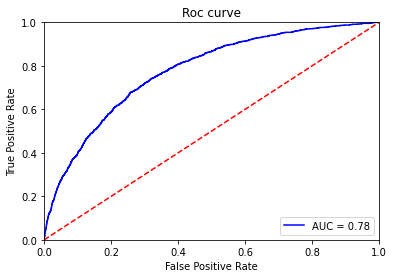

In [26]:
# plot roc curve
import matplotlib.pyplot as plt
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [27]:
test_df2['y_proba'] = y_proba

In [28]:
roc_auc

0.7770317874052084

In [32]:
len(test_df2)

13371

In [30]:
test_df2.y_proba.describe()

count    13371.000000
mean         0.103010
std          0.111715
min          0.003692
25%          0.029681
50%          0.060649
75%          0.130984
max          0.817838
Name: y_proba, dtype: float64

In [34]:
test_df2['TARGET'].value_counts()

0    11998
1     1373
Name: TARGET, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
test_df2['y_proba2'] = np.where(test_df2['y_proba']>= (1-roc_auc), 1 , 0)

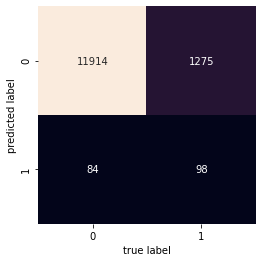

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

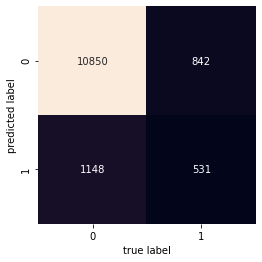

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, test_df2['y_proba2'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [42]:
test_df2.y_proba2.value_counts()

0    11692
1     1679
Name: y_proba2, dtype: int64

In [ ]:
test_df2['finance'] = np.nan

In [50]:
test_df2.AMT_CREDIT.mean() *0.05

27454.840857078754

### reloading

In [136]:
data_directory = r'C:\Users\juvaugha\Documents\PYTHON\OPCR PROJECTS\projet 7\pickled/'

# import df and model
model = joblib.load(data_directory + 'lgb.pkl')

train_df = pd.read_pickle(data_directory + "train_df.pkl")
test_df = pd.read_pickle((data_directory + "test_df.pkl"))

In [137]:
test_df2 = test_df.copy()

In [138]:
avg_lost_per_default = -(test_df2.AMT_CREDIT.mean() *0.50)
avg_gain_per_good_customer = test_df2.AMT_CREDIT.mean() *0.05

In [139]:
proba_diff = [-.2, -0.1, -.05, 0, 0.5, 0.1, 2]

In [140]:
y_proba = model.predict_proba(test_df.drop(columns = ['TARGET',]), num_iteration=model.best_iteration_)[:, 1]

In [141]:
test_df.index

Int64Index([439442, 340600, 157696, 266672, 378316, 108209, 321084, 439094,
            326816, 125762,
            ...
            141930, 291111, 236488, 373952, 221009, 443603, 351791, 432494,
            275491, 348215],
           dtype='int64', name='SK_ID_CURR', length=13371)

In [144]:
ind = 157696

In [146]:
model.predict_proba(test_df.loc[[ind]].drop(columns = ['TARGET',]), num_iteration=model.best_iteration_)[:, 1]

array([0.1623608])

In [143]:
y_proba = model.predict_proba(test_df.drop(columns = ['TARGET',]), num_iteration=model.best_iteration_)[:, 1]

array([0.1623608])

In [147]:
train_proba = model.predict_proba(train_df.drop(columns = ['TARGET',]), num_iteration=model.best_iteration_)[:, 1]

In [111]:
test_df2['y_proba'] = y_proba

In [112]:
test_df2['y_proba2'] = np.where(test_df2['y_proba']>= (1-roc_auc), 1 , 0)

In [113]:
fpr, tpr, threshold = metrics.roc_curve(test_df2['TARGET'], y_proba, )
roc_auc = metrics.auc(fpr, tpr)

In [114]:
roc_auc

0.7770317874052084

In [115]:
def find_optimal_proba(optimal_proba, avg_lost_per_default, avg_gain_per_good_customer):
    test_df2['finance'] = np.nan   
    test_df2['y_proba2'] = np.where(test_df2['y_proba']>= (1- optimal_proba), 1 , 0)


    test_df2['finance'] = np.where((test_df2['TARGET']==0) & (test_df2['y_proba2']==0), avg_gain_per_good_customer, test_df2['finance'])
    test_df2['finance'] = np.where((test_df2['TARGET']==0) & (test_df2['y_proba2']==1), -avg_gain_per_good_customer, test_df2['finance'])
    test_df2['finance'] = np.where((test_df2['TARGET']==1) & (test_df2['y_proba2']==0), avg_lost_per_default, test_df2['finance'])
    test_df2['finance'] = np.where((test_df2['TARGET']==1) & (test_df2['y_proba2']==1), -avg_lost_per_default, test_df2['finance'])

    return (test_df2['finance'].sum())

In [3]:
from scipy.optimize import minimize 


In [38]:
minimize(find_optimal_proba, x0, args=(-(test_df2.AMT_CREDIT.mean() *0.50), test_df2.AMT_CREDIT.mean() *0.05) )

NameError: name 'x0' is not defined

In [116]:
roc_auc

0.7770317874052084

In [117]:
temp_proba_list = []
for i in range(-50,50,3):
    temp_proba_list.append(roc_auc+ i/100)

In [118]:
temp_proba_list

[0.2770317874052084,
 0.3070317874052084,
 0.3370317874052084,
 0.3670317874052084,
 0.3970317874052084,
 0.4270317874052084,
 0.4570317874052084,
 0.4870317874052084,
 0.5170317874052084,
 0.5470317874052084,
 0.5770317874052084,
 0.6070317874052084,
 0.6370317874052084,
 0.6670317874052084,
 0.6970317874052084,
 0.7270317874052084,
 0.7570317874052084,
 0.7870317874052084,
 0.8170317874052084,
 0.8470317874052085,
 0.8770317874052084,
 0.9070317874052084,
 0.9370317874052084,
 0.9670317874052083,
 0.9970317874052084,
 1.0270317874052084,
 1.0570317874052084,
 1.0870317874052084,
 1.1170317874052085,
 1.1470317874052083,
 1.1770317874052085,
 1.2070317874052083,
 1.2370317874052084,
 1.2670317874052084]

In [119]:
avg_lost_per_default = -(test_df2.AMT_CREDIT.mean() *0.50)
avg_gain_per_good_customer = test_df2.AMT_CREDIT.mean() *0.05

In [164]:
test_df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
439442,1,0,0,0,112500.0,518071.5,36184.5,459000.0,0.018850,-23255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
340600,1,0,0,0,126000.0,585000.0,18999.0,585000.0,0.028663,-17106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0
157696,0,1,1,0,247500.0,509400.0,40243.5,450000.0,0.003541,-23103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
266672,1,1,0,0,157500.0,545040.0,30564.0,450000.0,0.010006,-17802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
378316,0,0,0,0,121500.0,495000.0,21933.0,495000.0,0.031329,-20956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443603,1,1,0,0,270000.0,545040.0,26640.0,450000.0,0.019101,-17480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
351791,1,1,0,0,405000.0,495000.0,48352.5,495000.0,0.026392,-14332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
432494,0,1,0,0,202500.0,640080.0,29970.0,450000.0,0.022625,-21795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [177]:
test_df2['y_proba'] = y_proba

0.87
Based on the information imputed here is the graph of returns on the training data


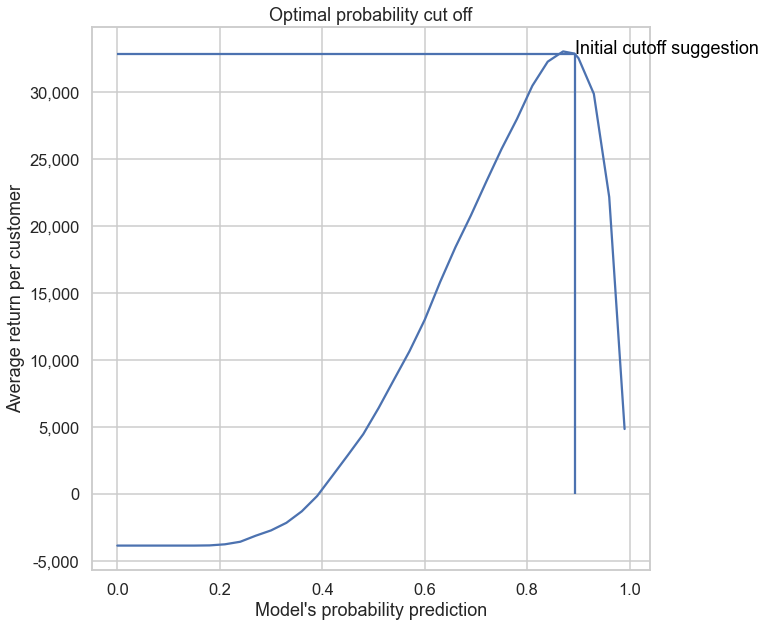

In [355]:
optimal_proba_result = 0
plot_proba = {}
for proba in temp_proba_list:

    train_df['finance'] = np.nan   
    train_df['y_proba2'] = np.where(train_df['proba']>= (1 - proba), 1 , 0)


    train_df['finance'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==0), avg_gain_per_good_customer, train_df['finance'])
    train_df['finance'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==1), -avg_gain_per_good_customer, train_df['finance'])
    train_df['finance'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==0), avg_lost_per_default, train_df['finance'])
    train_df['finance'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==1), -avg_lost_per_default, train_df['finance'])

    gains = train_df['finance'].sum().round(2)/len(train_df)
    plot_proba[proba] = gains
    
    if gains > optimal_proba_result:
        optimal_proba_result = gains
        optimal_proba = proba
        
print(optimal_proba)
print_return_graph(plot_proba)

In [121]:
import seaborn as sns

In [178]:
sns.set_style("whitegrid")
sns.set_context('talk')

In [123]:
import matplotlib.ticker as mtick

In [124]:
plot_proba.values()

dict_values([-45959403.59, -43268829.19, -39644790.2, -35746202.8, -31847615.39, -21908963.0, -15868898.02, -6149884.35, 9554284.62, 23062066.32, 36734577.07, 51230733.04, 71437495.91, 97519594.72, 123272235.45, 139800049.64, 168243264.77, 192019156.95, 224910056.3, 247807393.58, 275701511.89, 296512281.26, 288440558.04, 210468810.01, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36])

In [ ]:
288 440 558

In [170]:
sum(plot_proba.values())

2691837326.630001

In [179]:
plot_proba.values()

dict_values([-3437.245051978162, -3236.020431530925, -2964.983187495326, -2673.412818786927, -2381.842449330641, -1638.5433400643183, -1186.8146002542817, -459.9419901278887, 714.5527350235584, 1724.7824635404982, 2747.3320671602723, 3831.481044050557, 5342.719012040984, 7293.365845486501, 9219.372930222124, 10455.46702864408, 12582.69873382694, 14360.867321067983, 16820.73564430484, 18533.19823349039, 20619.36368932765, 22175.774531448656, 21572.100668611176, 15740.693292199536, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088, 3556.337174482088])

In [173]:
plot_proba.values()/len()

dict_values([-45959403.59, -43268829.19, -39644790.2, -35746202.8, -31847615.39, -21908963.0, -15868898.02, -6149884.35, 9554284.62, 23062066.32, 36734577.07, 51230733.04, 71437495.91, 97519594.72, 123272235.45, 139800049.64, 168243264.77, 192019156.95, 224910056.3, 247807393.58, 275701511.89, 296512281.26, 288440558.04, 210468810.01, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36, 47551784.36])

In [166]:
plot_proba.keys().values

AttributeError: 'dict_keys' object has no attribute 'values'

In [ ]:
test_df2['y_proba2'] = np.where(test_df2['y_proba']>= (1 - proba), 1 , 0)

In [427]:
opt_perc

0.93

### vs code checking

In [184]:
def initial_cut_off_suggestion (train_df, model):
    train_proba = model.predict_proba(train_df.drop(columns = ['TARGET',]), num_iteration=model.best_iteration_)[:, 1]
    train_df['proba'] = train_proba

    fpr, tpr, threshold = metrics.roc_curve(train_df['TARGET'], train_proba, )
    suggested_initial_cut_off = metrics.auc(fpr, tpr)
    return suggested_initial_cut_off

In [404]:
avg_interest

0.03

In [405]:
avg_reimbursed_b4_default

0.4

Based on the information imputed here is the graph of returns on the training data


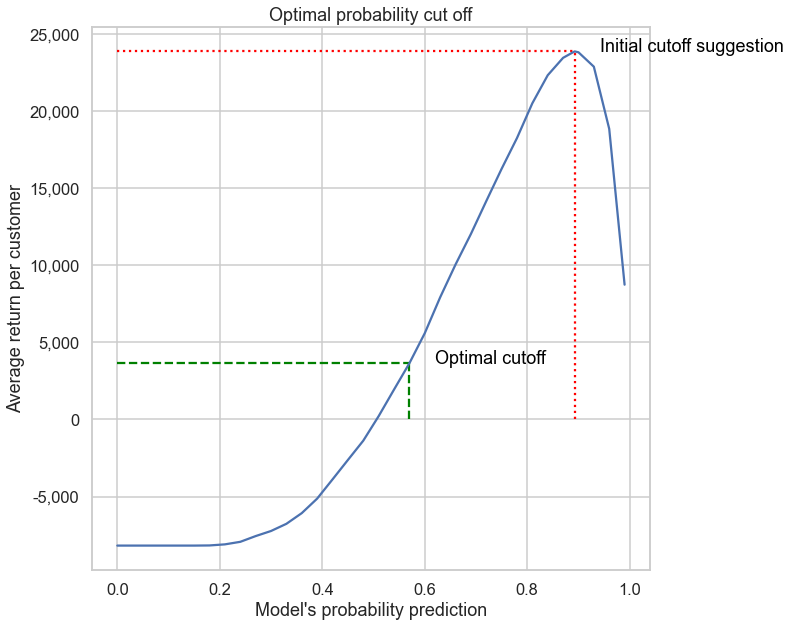

In [402]:
temp_proba_list = []
for i in range(0,100,3):
    temp_proba_list.append(i/100)
temp_proba_list.append(suggested_initial_cut_off)


optimal_proba_result = 0
plot_proba = {}

train_df['potential_gain'] = avg_interest * train_df['AMT_CREDIT']
train_df['potential_loss'] = avg_reimbursed_b4_default * train_df['AMT_CREDIT']

for proba in sorted(temp_proba_list):
    train_df['result'] = np.nan   
    train_df['y_proba2'] = np.where(train_df['proba']>= (1 - proba), 1 , 0)

    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==0), train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==1), -train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==0), -train_df['potential_loss'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==1), train_df['potential_loss'], train_df['result'])


    avg_gains = train_df['result'].sum() / len(train_df)
    plot_proba[proba] = avg_gains

    if avg_gains > optimal_proba_result:
        optimal_proba_result = avg_gains
        optimal_proba = proba
print_return_graph(plot_proba)

In [384]:
def find_optimal_proba (test_df ,train_df):
    print('Customer class information')
    print('Average credit: ', int(test_df.AMT_CREDIT.mean()))
    print('Maximum credit: ', int(test_df.AMT_CREDIT.max()))
    print('Minimum credit: ', int(test_df.AMT_CREDIT.min()))
    print()

    print('Average credit percentage reimbursed before default? Input a number between 0 and 1')
    avg_reimbursed_b4_default = float(input())
    print('Enter customer Interest rate or average of customer group above. Input a number between 0 and 1')
    avg_interest = float(input())

    temp_proba_list = []
    for i in range(0,100,3):
        temp_proba_list.append(i/100)
    temp_proba_list.append(suggested_initial_cut_off)


    optimal_proba_result = 0
    plot_proba = {}

    train_df['potential_gain'] = avg_interest * train_df['AMT_CREDIT']
    train_df['potential_loss'] = avg_reimbursed_b4_default * train_df['AMT_CREDIT']

    for proba in sorted(temp_proba_list):
        train_df['result'] = np.nan   
        train_df['y_proba2'] = np.where(train_df['proba']>= (1 - proba), 1 , 0)

        train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==0), train_df['potential_gain'], train_df['result'])
        train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==1), -train_df['potential_gain'], train_df['result'])
        train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==0), -train_df['potential_loss'], train_df['result'])
        train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==1), train_df['potential_loss'], train_df['result'])


        avg_gains = train_df['result'].sum() / len(train_df)
        plot_proba[proba] = avg_gains

        if avg_gains > optimal_proba_result:
            optimal_proba_result = avg_gains
            optimal_proba = proba
            
    return optimal_proba, plot_proba

In [425]:
def print_return_graph(plot_proba):
    print('Based on the information imputed here is the graph of returns on the training data')

    plt.figure(figsize=(10,10))
    plt.title('Optimal probability cut off')
    ax = sns.lineplot(x= plot_proba.keys(), y =plot_proba.values())
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)  
    
    # plot square on initial suggested cut off
    plt.vlines(x = suggested_initial_cut_off, ymin=[0], ymax=plot_proba[suggested_initial_cut_off],  linestyle='dotted', color = 'red', label = 'Initial cutoff suggestion' )
    plt.hlines(y = plot_proba[suggested_initial_cut_off], xmin=[0], xmax=suggested_initial_cut_off, linestyle='dotted', color = 'red')
    #plt.text(suggested_initial_cut_off+.01, plot_proba[suggested_initial_cut_off] - plot_proba[suggested_initial_cut_off]*.1, 'Initial cutoff suggestion', horizontalalignment='left', size='medium', color='black')
    
    # plot square on optimal suggested cut off
    plt.vlines(x = opt_perc, ymin=[0], ymax=plot_proba[opt_perc],  linestyle='dashed', color = 'green', label= 'Optimal cutoff ' )
    plt.hlines(y = plot_proba[opt_perc], xmin=[0], xmax=opt_perc, linestyle='dashed', color = 'green')
    #plt.text(opt_perc+.01, plot_proba[opt_perc] + plot_proba[opt_perc]*.1, , horizontalalignment='left', size='medium', color='black')
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("Model's probability prediction")
    plt.ylabel("Average return per customer")
    plt.show()

In [386]:
train_df.drop(columns = 'proba', inplace=True)

In [392]:
suggested_initial_cut_off = initial_cut_off_suggestion(train_df, model)

In [417]:
opt_perc, plot_dic = find_optimal_proba(test_df2, train_df)

Customer class information
Average credit:  549096
Maximum credit:  659610
Minimum credit:  454810

Average credit percentage reimbursed before default? Input a number between 0 and 1


 .6


Enter customer Interest rate or average of customer group above. Input a number between 0 and 1


 .02


In [430]:
max(plot_dic, key=plot_dic.get)

0.93

In [428]:
plot_dic

{0.0: -24562.976497382202,
 0.03: -24562.976497382202,
 0.06: -24562.976497382202,
 0.09: -24562.976497382202,
 0.12: -24562.976497382202,
 0.15: -24562.976497382202,
 0.18: -24548.79405908751,
 0.21: -24443.6212842184,
 0.24: -24196.27799326851,
 0.27: -23636.979444278237,
 0.3: -23141.91993792072,
 0.33: -22439.738986537024,
 0.36: -21397.3459723261,
 0.39: -19977.47343231114,
 0.42: -18102.789861630517,
 0.45: -16201.313454749437,
 0.48: -14308.473614809276,
 0.51: -11889.227836200449,
 0.54: -9262.409068810768,
 0.57: -6652.636974569931,
 0.6: -3654.6644988780854,
 0.63: -66.53280852655233,
 0.66: 3264.7212857142854,
 0.69: 6423.921300673149,
 0.72: 9895.222247569185,
 0.75: 13401.311840688104,
 0.78: 16886.89145474944,
 0.81: 20929.87056170531,
 0.84: 24536.161698578904,
 0.87: 27492.169357516825,
 0.8925151240820621: 29454.24119147345,
 0.9: 29916.034848915482,
 0.93: 31452.265447270005,
 0.96: 30707.103601346294,
 0.99: 24902.96163275991}

Based on the information imputed here is the graph of returns on the training data


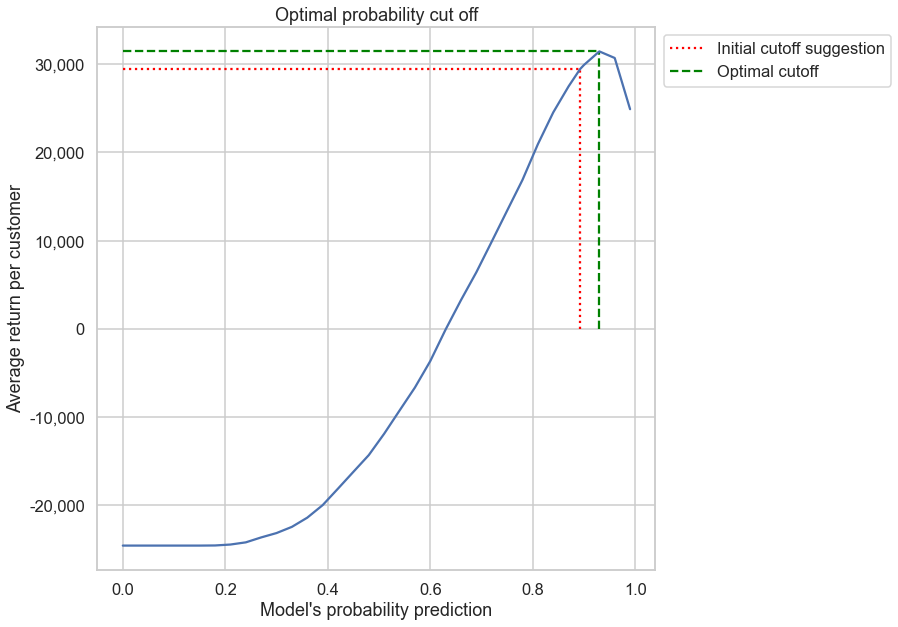

In [426]:
print_return_graph(plot_dic)

In [203]:
opt_perc

44372.421676514576

In [336]:
avg_interest

0.08

In [337]:
avg_reimbursed_b4_default

0.2

In [343]:
avg_interest=.05


In [344]:
avg_reimbursed_b4_default= 0 

In [349]:
train_df['proba'].describe()

count    40110.000000
mean         0.105263
std          0.120113
min          0.003598
25%          0.029171
50%          0.058595
75%          0.130809
max          0.835832
Name: proba, dtype: float64

In [359]:
avg_gain_per_good_customer

27454.840857078754

In [360]:
avg_lost_per_default

-274548.4085707875

In [363]:
optimal_proba

0.87

In [364]:
train_df['y_proba2'] = np.where(train_df['proba']>= (1 - optimal_proba), 1 , 0)

In [366]:
train_df['y_proba2'].value_counts()

0    30005
1    10105
Name: y_proba2, dtype: int64

In [367]:
train_df['TARGET'].value_counts()

0    35949
1     4161
Name: TARGET, dtype: int64

In [368]:
avg_gain_per_good_customer

27454.840857078754

In [403]:
plot_proba

{0.0: -8181.97295474944,
 0.03: -8181.97295474944,
 0.06: -8181.97295474944,
 0.09: -8181.97295474944,
 0.12: -8181.97295474944,
 0.15: -8181.97295474944,
 0.18: -8172.517995886314,
 0.21: -8102.402812640241,
 0.24: -7937.507285340316,
 0.27: -7565.527749065072,
 0.3: -7235.488078160061,
 0.33: -6769.665903141363,
 0.36: -6076.6082816006,
 0.39: -5136.5532486911015,
 0.42: -3891.056538893045,
 0.45: -2631.9267453253565,
 0.48: -1381.8816451009734,
 0.51: 207.8660430067304,
 0.54: 1930.9226533283463,
 0.57: 3636.581729618548,
 0.6: 5584.312096110694,
 0.63: 7907.277245699325,
 0.66: 10033.788005609573,
 0.69: 12014.11248578908,
 0.72: 14146.539037023185,
 0.75: 16241.178176140613,
 0.78: 18237.533610695587,
 0.81: 20493.949241959614,
 0.84: 22310.04585751683,
 0.87: 23438.1757079282,
 0.8925151240820621: 23854.258701944655,
 0.9: 23797.217998878084,
 0.93: 22863.797740837697,
 0.96: 18835.51252617801,
 0.99: 8732.02029132386}

Based on the information imputed here is the graph of returns on the training data


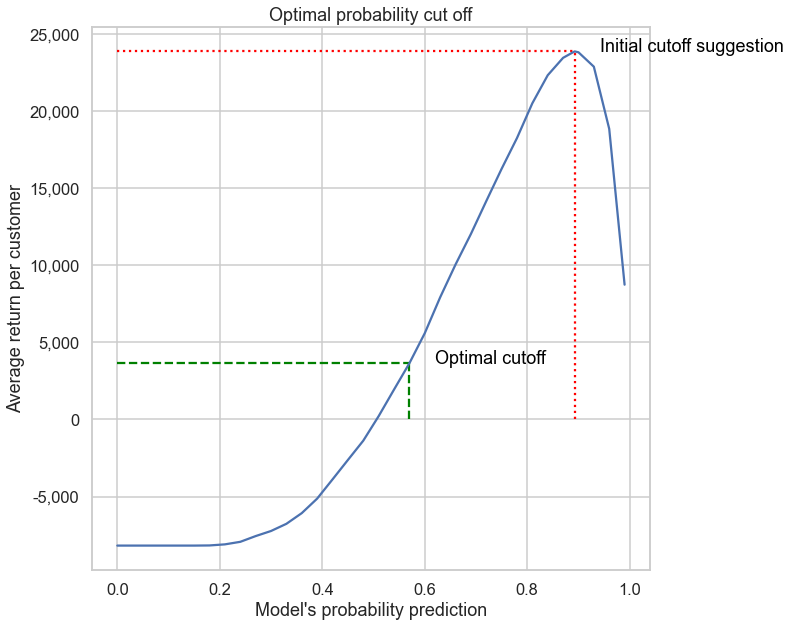

In [402]:
temp_proba_list = []
for i in range(0,100,3):
    temp_proba_list.append(i/100)
temp_proba_list.append(suggested_initial_cut_off)


optimal_proba_result = 0
plot_proba = {}

train_df['potential_gain'] = avg_interest * train_df['AMT_CREDIT']
train_df['potential_loss'] = avg_reimbursed_b4_default * train_df['AMT_CREDIT']

for proba in sorted(temp_proba_list):
    train_df['result'] = np.nan   
    train_df['y_proba2'] = np.where(train_df['proba']>= (1 - proba), 1 , 0)

    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==0), train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==1), -train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==0), -train_df['potential_loss'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==1), train_df['potential_loss'], train_df['result'])


    avg_gains = train_df['result'].sum() / len(train_df)
    plot_proba[proba] = avg_gains

    if avg_gains > optimal_proba_result:
        optimal_proba_result = avg_gains
        optimal_proba = proba
print_return_graph(plot_proba)

In [342]:
train_df['result'].value_counts()

0.00         12239
43603.20      1545
41702.40      1202
40679.64      1048
39801.60       767
             ...  
46785.60         1
36724.68         1
98910.00         1
92439.00         1
121836.60        1
Name: result, Length: 932, dtype: int64

Based on the information imputed here is the graph of returns on the training data


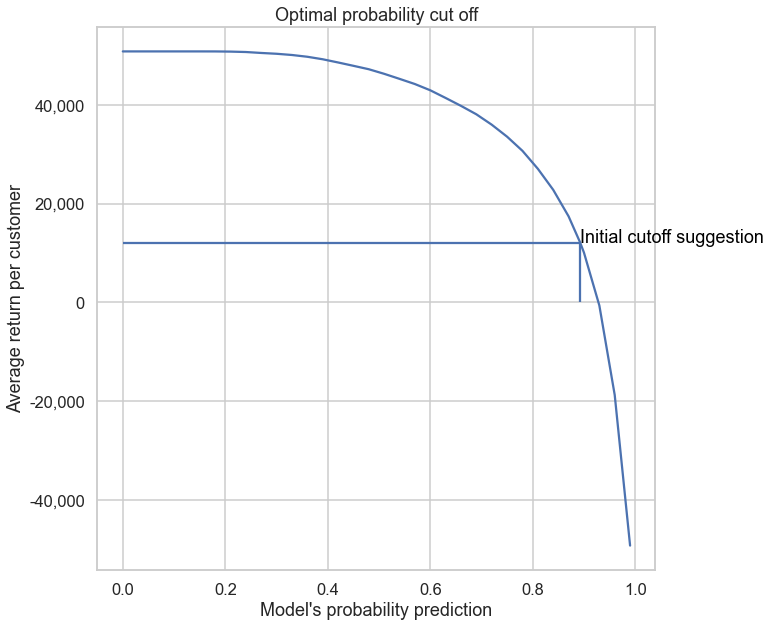

In [339]:
temp_proba_list = []
for i in range(0,100,3):
    temp_proba_list.append(i/100)
temp_proba_list.append(suggested_initial_cut_off)


optimal_proba_result = 0
plot_proba = {}

train_df['potential_gain'] = avg_interest * train_df['AMT_CREDIT']
train_df['potential_loss'] = avg_reimbursed_b4_default * train_df['AMT_CREDIT']

for proba in temp_proba_list:

    train_df['result'] = np.nan   
    train_df['y_proba2'] = np.where(train_df['proba']>= (1 - proba), 1 , 0)

    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==0), train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==0) & (train_df['y_proba2']==1), -train_df['potential_gain'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==0), train_df['potential_loss'], train_df['result'])
    train_df['result'] = np.where((train_df['TARGET']==1) & (train_df['y_proba2']==1), -train_df['potential_loss'], train_df['result'])


    avg_gains = train_df['result'].sum() / len(train_df)
    plot_proba[proba] = avg_gains

    if avg_gains > optimal_proba_result:
        optimal_proba_result = avg_gains
        optimal_proba = proba
        
print_return_graph(plot_proba)

## Using SHAP (SHapley Additive exPlanations)

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(models[0], num_iteration=models[0].best_iteration_)
shap_values = explainer.shap_values(train_df)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# visualize the first prediction's explanation (in log-odds scale)
print('Model prediction:', models[0].predict_proba(train_df[:1], num_iteration=models[0].best_iteration_)[:,1])
shap.force_plot(shap_values[0,:], train_df.iloc[0,:])

In [ ]:
# Reconstructing the lgb output from shap_values:
def inv_logit(p): return np.exp(p) / (1 + np.exp(p))
base_value = shap_values[0,-1]  ## this old version of shap uses the last index to store the base value
output = base_value + np.sum(shap_values[0,:-1])  ## the remaining indexes are the the linear/additive contributions of each feature

print('Log-odds output:', output, ' Logistic output:', inv_logit(output))

In [ ]:
# visualize the training set predictions
shap.force_plot(shap_values[::2000], train_df[::2000])

In [ ]:
# summarize the effects of top features
shap.summary_plot(shap_values, train_df, max_display=30)

## Select Best Features
To avoid fitting to noise and improve our LB score ;)

In [ ]:
percentile = 0.15 ## tweak me
best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean']) \
                                                           .sort_values(by="mean", ascending=False).reset_index()
best_features = best_features[:int(best_features.shape[0]*percentile)]["feature"].values
print("## Using {} features =".format(len(best_features)), best_features)
with timer("Run LightGBM with kfold"):
    train_df = train_df[best_features]
    test_df = test_df[best_features]
    feat_importance, models, scores = kfold_lightgbm(train_df, train_target, test_df, num_folds=5, stratified=False, debug=debug)

In [ ]:
train_df.head(1)

serveur.py
api en local


In [ ]:
API,
dd
https://www.youtube.com/watch?v=MwZwr5Tvyxo

